In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from hep_VQAE import data_preprocessing as dp
import tensorflow as tf
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import time

import warnings
warnings.filterwarnings('ignore')

2022-08-09 13:47:37.709763: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-09 13:47:37.709787: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Circuit

In [2]:
DATA_QBITS = 6
LATENT_QBITS = 4
TRASH_QBITS = DATA_QBITS - LATENT_QBITS
TOTAL_QBITS = DATA_QBITS + TRASH_QBITS + 1

INPUT_DATA_SIZE = 8

In [3]:
dev1 = qml.device('lightning.qubit', wires=TOTAL_QBITS)

In [4]:
@qml.qnode(dev1)
def circuit(enc_params, data):
    qml.AmplitudeEmbedding(data, wires=range(DATA_QBITS), normalize=True)
    qml.BasicEntanglerLayers(enc_params, wires=range(DATA_QBITS))
    qml.Hadamard(wires=TOTAL_QBITS-1)
    for i in range(TRASH_QBITS):
        #c += cirq.ControlledGate(sub_gate=cirq.SWAP, num_controls=1).on(swap_qbit, reference_qbits[i], network_qbits[num_data_qbits - num_latent_qbits:][i])
        qml.CSWAP(wires=[TOTAL_QBITS - 1, LATENT_QBITS + i, DATA_QBITS + i])
    qml.Hadamard(wires=TOTAL_QBITS-1)
    return qml.expval(qml.PauliZ(TOTAL_QBITS-1))

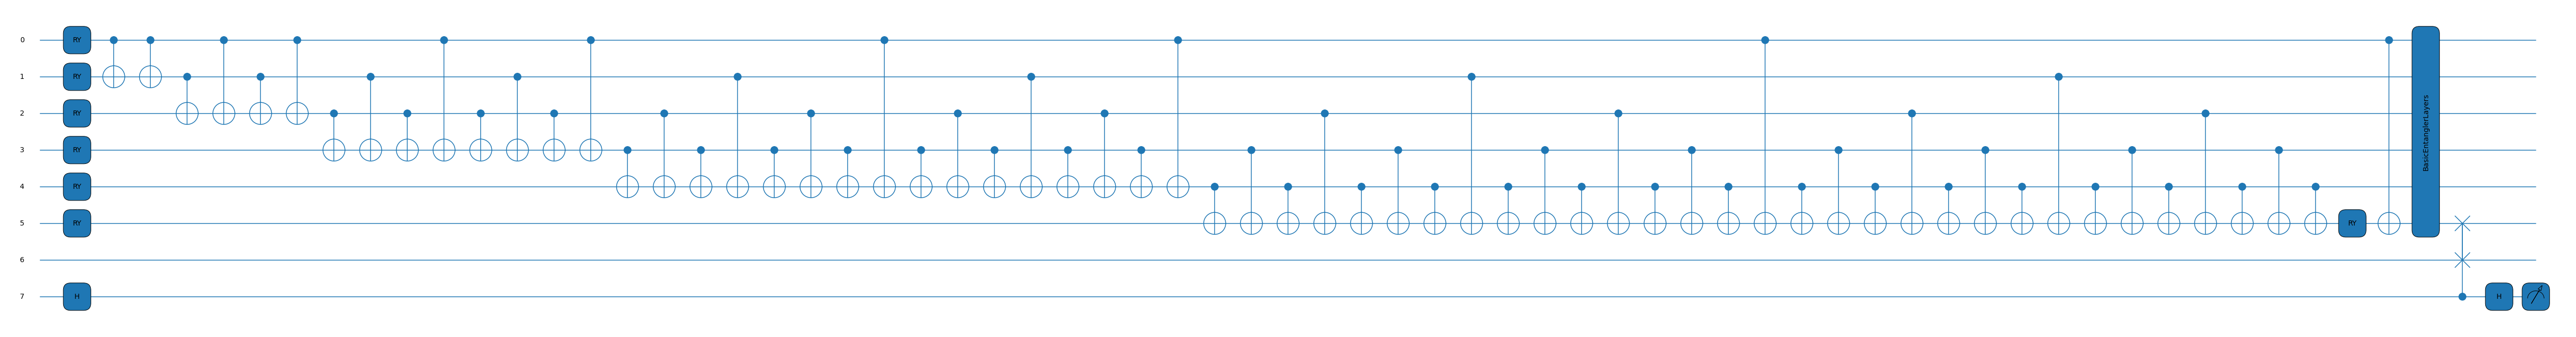

In [5]:
fig, ax = qml.draw_mpl(circuit)([[1,1,1,1,1,1]],np.ones(64)/64**0.5)
fig.show()

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

In [7]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

In [8]:
x_train_threes = np.array(x_train[y_train==True])
x_train = np.array(x_train[y_train==False])

x_test_threes = np.array(x_test[y_test==True])
x_test = np.array(x_test[y_test==False])

In [9]:
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],x_train.shape[2],1))
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],x_test.shape[2],1))

x_train_threes = x_train_threes.reshape((x_train_threes.shape[0],x_train_threes.shape[1],x_train_threes.shape[2],1))
x_test_threes = x_test_threes.reshape((x_test_threes.shape[0],x_test_threes.shape[1],x_test_threes.shape[2],1))

In [10]:
x_train_small = tf.image.resize(x_train, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()
x_test_small = tf.image.resize(x_test, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()

x_train_3_small = tf.image.resize(x_train_threes, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()
x_test_3_small = tf.image.resize(x_test_threes, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()

2022-08-09 13:47:40.386436: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-09 13:47:40.386467: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-09 13:47:40.386490: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-08-09 13:47:40.386871: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


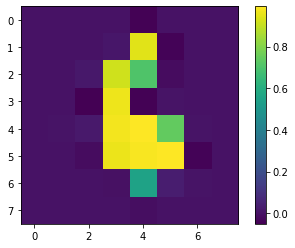

In [11]:
plt.imshow(x_train_small[3].reshape((x_train_small.shape[1],x_train_small.shape[2])))
plt.colorbar()

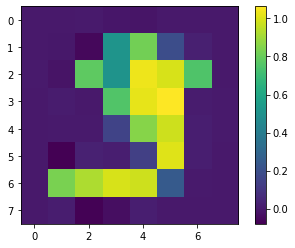

In [12]:
plt.imshow(x_train_3_small[3].reshape((x_train_3_small.shape[1],x_train_3_small.shape[2])))
plt.colorbar()

In [13]:
LAYERS = 8

def cost(params, X):
    loss = 0.0
    for i in range(len(X)):
        f = circuit(params, X[i])
        loss = loss + (1 - f) ** 2
    return loss / len(X)

In [14]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

In [15]:
learning_rate = 0.01
epochs = 15
batch_size = 20

In [16]:
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
# opt = qml.QNGOptimizer(learning_rate)
#opt = GradientDescentOptimizer(learning_rate)

In [17]:
weight_shapes = {"weights": (LAYERS, DATA_QBITS)}
params = np.random.uniform(size=weight_shapes["weights"], requires_grad=True)

In [18]:
params.shape

(8, 6)

In [19]:
x_train_small = x_train_small[:1200].reshape((1200,8*8))
x_train_3_small = x_train_3_small[:1200].reshape((1200,8*8))

x_test_small = x_train_small[:1200].reshape((1200,8*8))
x_test_3_small = x_train_3_small[:1200].reshape((1200,8*8))

In [20]:
start = time.time()

for it in range(epochs):
    for j,Xbatch in enumerate(iterate_minibatches(x_train_small, batch_size=batch_size)):
        params, _ = opt.step(cost, params, Xbatch)
        print(j, end="\r")

    loss = cost(params, x_train_small)
    val_loss = cost(params, x_test_small[:100])
    
    print(f"Epoch: {it} | Loss: {loss:.3} | Val Loss: {val_loss:.3}")
    
end = time.time()

print(f"Time for {epochs} epochs with {LAYERS} layers: {end - start}")

Epoch: 0 | Loss: 0.195 | Val Loss: 0.196
Epoch: 1 | Loss: 0.188 | Val Loss: 0.188
Epoch: 2 | Loss: 0.183 | Val Loss: 0.184
Epoch: 3 | Loss: 0.182 | Val Loss: 0.184
Epoch: 4 | Loss: 0.182 | Val Loss: 0.183
Epoch: 5 | Loss: 0.182 | Val Loss: 0.183
Epoch: 6 | Loss: 0.182 | Val Loss: 0.183
Epoch: 7 | Loss: 0.182 | Val Loss: 0.183
Epoch: 8 | Loss: 0.182 | Val Loss: 0.183
Epoch: 9 | Loss: 0.182 | Val Loss: 0.182
Epoch: 10 | Loss: 0.182 | Val Loss: 0.182
Epoch: 11 | Loss: 0.182 | Val Loss: 0.181
Epoch: 12 | Loss: 0.182 | Val Loss: 0.181
Epoch: 13 | Loss: 0.182 | Val Loss: 0.181
Epoch: 14 | Loss: 0.182 | Val Loss: 0.181
Time for 15 epochs with 8 layers: 10363.921728134155


In [23]:
x_test_threes = x_test_threes[:100]
x_test = x_test[:100]

In [45]:
x_test_s = x_test_small.reshape((1200,8*8))
x_test_3_s = x_test_3_small.reshape((1200,8*8))

In [46]:
pred_six = np.array([circuit(params,i) for i in x_test_s])
np.mean(pred_six)
print("Median six reconstruciton fidelities: ",np.median(pred_six))

pred_three = np.array([circuit(params,i) for i in x_test_3_s])
np.mean(pred_three)
print("Median three reconstruciton fidelities: ",np.median(pred_three))

Median six reconstruciton fidelities:  0.5791327270890949
Median three reconstruciton fidelities:  0.5154585354586461


(array([  8.,  63., 106., 178., 242., 268., 222.,  98.,  13.,   2.]),
 array([0.27995488, 0.32702478, 0.37409467, 0.42116457, 0.46823447,
        0.51530437, 0.56237426, 0.60944416, 0.65651406, 0.70358396,
        0.75065385]),
 [<matplotlib.patches.Polygon at 0x7fb7f589ec40>])

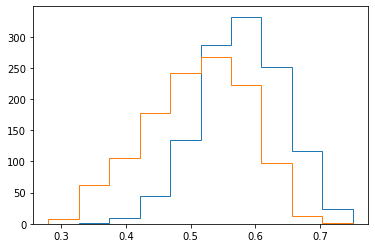

In [47]:
bins = np.histogram(np.hstack((pred_six.reshape((pred_six.shape[0],)), pred_three.reshape((pred_three.shape[0],)))), bins=10)[1]
plt.hist(pred_six, histtype='step', label="sixes",bins=bins)
plt.hist(pred_three, histtype='step', label="threes",bins=bins)

AUC:  0.7468805555555555


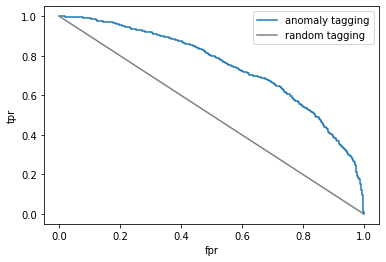

In [48]:
from sklearn.metrics import roc_auc_score, roc_curve

bce_background = 1-pred_six
bce_signal = 1-pred_three

y_true = np.append(np.zeros(len(bce_background)), np.ones(len(bce_signal)))
y_pred = np.append(bce_background, bce_signal)
auc = roc_auc_score(y_true, y_pred)

print("AUC: ", auc)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
tnr = 1 - fpr
x = np.linspace(0,1,50)
y_rnd = 1 - x
plt.plot(tnr,tpr, label="anomaly tagging")
plt.plot(x,y_rnd, label="random tagging", color='grey')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()

0.745


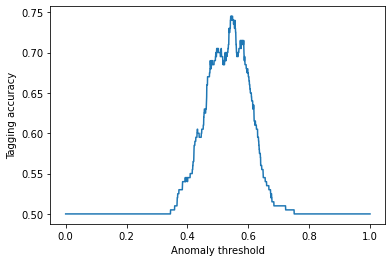

In [32]:
def acc_for_threshold(T):
    # sixes that are predicted six
    num_six_right = np.sum(pred_six > T)
    # threes that are predicted three
    num_three_right = np.sum(pred_three < T)
    acc = (num_six_right + num_three_right)/(len(pred_six) + len(pred_three))
    return acc

Ts = np.linspace(0,1,2000)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
print(max(accs))
plt.ylabel("Tagging accuracy")
plt.xlabel("Anomaly threshold")
plt.plot(Ts, accs)  